In [1]:
import os
import json
import ee
import geemap
import xarray as xr
import wxee
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON

In [2]:
# ee.Authenticate()

In [1]:
ee.Initialize()
wxee.Initialize()

NameError: name 'ee' is not defined

In [3]:
file_path = os.path.abspath("data/resourceshedbb_CostaRica_SanJose.geojson")

with open(file_path) as f:
    json_data = json.load(f)

bbox_geojson = geojson_to_ee(json_data)
bbox = bbox_geojson.geometry().bounds()

In [29]:
# Load the HydroSHEDS Flow Direction dataset and the specified Flow Accumulation dataset
flow_direction = ee.Image('WWF/HydroSHEDS/03DIR').clip(bbox)

crs = flow_direction.projection().crs() #4326

# Function to reduce resolution of an image
def reduce_resolution(image, reducer, scale):
    return image.reduceResolution(reducer=reducer, maxPixels=1024) \
                .reproject(crs=crs, scale=scale)

# Define the scale for 100m resolution
scale_100m = 100

flow_direction_100m = reduce_resolution(flow_direction, ee.Reducer.mean(), scale_100m)

flow_accumulation_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/base-network-layers/flow_accumulation").filterBounds(bbox)
flow_accumulation = flow_accumulation_collection.first().select('b1').clip(bbox)
flow_accumulation_100m = reduce_resolution(flow_accumulation, ee.Reducer.mean(), scale_100m)

stream_dist_proximity_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/stream-outlet-distance/stream_dist_proximity").filterBounds(bbox)
stream_dist_proximity = stream_dist_proximity_collection.first().select('b1').clip(bbox)
stream_dist_proximity_100m = reduce_resolution(stream_dist_proximity, ee.Reducer.mean(), scale_100m)

spi_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/flow_index/spi").filterBounds(bbox)
spi_image = spi_collection.first().select('b1').clip(bbox)
spi_image_100m = reduce_resolution(spi_image, ee.Reducer.mean(), scale_100m)

sti_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/flow_index/sti").filterBounds(bbox)
sti_image = sti_collection.first().select('b1').clip(bbox)
sti_image_100m = reduce_resolution(sti_image, ee.Reducer.mean(), scale_100m)

cti_collection = ee.ImageCollection("projects/sat-io/open-datasets/HYDROGRAPHY90/flow_index/cti").filterBounds(bbox)
cti_image = cti_collection.first().select('b1').clip(bbox)
cti_image_100m = reduce_resolution(cti_image, ee.Reducer.mean(), scale_100m)

tpi_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/tpi")
tpi_image = tpi_collection.first().select('b1').clip(bbox)
tpi_image_100m = reduce_resolution(tpi_image, ee.Reducer.mean(), scale_100m)

landcover = ee.Image("ESA/WorldCover/v100/2020").clip(bbox)
landcover_100m = reduce_resolution(landcover, ee.Reducer.mode(), scale_100m)# set to mode to get most common landcover class
 
ghsl = ee.ImageCollection("JRC/GHSL/P2023A/GHS_BUILT_C").filterBounds(bbox).first().select('built_characteristics').clip(bbox)
ghsl_100m = reduce_resolution(ghsl, ee.Reducer.mode(), scale_100m) # set to mode

pcurv_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/pcurv")
pcurv_image = pcurv_collection.first().select('b1').clip(bbox)
pcurv_image_100m = reduce_resolution(pcurv_image, ee.Reducer.mean(), scale_100m)

tcurv_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/tcurv")
tcurv_image = tcurv_collection.first().select('b1').clip(bbox)
tcurv_image_100m = reduce_resolution(tcurv_image, ee.Reducer.mean(), scale_100m)

hwsd2 = ee.Image("projects/sat-io/open-datasets/FAO/HWSD_V2_SMU").select('HWSD2_ID').clip(bbox)
hwsd2_100m = reduce_resolution(hwsd2, ee.Reducer.mode(), scale_100m) # set to mode

dem = ee.Image('USGS/SRTMGL1_003').clip(bbox)
dem_100m = reduce_resolution(dem, ee.Reducer.mean(), scale_100m)

slope = ee.Terrain.slope(dem)
slope_100m = reduce_resolution(slope, ee.Reducer.mean(), scale_100m)

aspect_collection = ee.ImageCollection("projects/sat-io/open-datasets/Geomorpho90m/aspect")
aspect_image = aspect_collection.first().select('b1').clip(bbox)
aspect_image_100m = reduce_resolution(aspect_image, ee.Reducer.mean(), scale_100m)

In [27]:
# Visualization Parameters
vis_params_dir = {'min': 0, 'max': 360, 'palette': ['blue', 'green', 'red']}
vis_params_dem = {'min': 0, 'max': 4000, 'palette': 'terrain'}
vis_params_slope = {'min': 0, 'max': 60, 'palette': ['black', 'blue', 'green', 'yellow', 'orange', 'red']}
vis_params_aspect = {'min': 0, 'max': 100, 'palette': ['black', 'blue', 'green', 'yellow', 'orange', 'red']}
vis_params_tpi = {'min': 0, 'max': 50, 'palette': ['white', 'purple']}
vis_params_tri = {'min': 0, 'max': 50, 'palette': ['white', 'green']}
vis_params_pcurv = {'min': -50, 'max': -5, 'palette': ['white', 'red']}
vis_params_tcurv = {'min': -50, 'max': -5, 'palette': ['white', 'yellow']}
vis_params_precipitation = {'min': 1, 'max': 17, 'palette': ['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000']}

# Note: The visualization parameters for flow accumulation, sti_image, cti_image, landcover, hwsd2, ghsl, and chirps_precip are not included in your original code. 
# You should define them similarly if needed.

In [23]:
scale = 100

chirps_precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filter(ee.Filter.date('2018-05-01', '2018-05-03')).select('precipitation').max().clip(bbox)
chirps_precip_100m = chirps_precip.resample('bicubic').reproject(
    crs=crs,
    scale=scale
)

precipitationVis = {'min': 1, 'max': 17, 'palette': ['001137', '0aab1e', 'e7eb05', 'ff4a2d', 'e90000'],}

In [20]:
m = geemap.Map()
m.add('layer_manager')
m.setCenter(-84.1, 9.9, 8)
m.addLayer(chirps_precip, precipitationVis, 'Precipitation')
m.addLayer(chirps_precip_100m, precipitationVis, 'Precipitation REsampled')
m

Map(center=[9.9, -84.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [28]:
# Create a map
Map = geemap.Map()
Map.add("basemap_selector")
Map.add("layer_manager")

# Center the map on San Jose, Costa Rica
Map.setCenter(-84.0833, 9.9333, 10)

# Add the flow direction and accumulation layers to the map
Map.addLayer(flow_direction_100m, vis_params_dir, 'Flow Direction 100m')
# Map.addLayer(bbox, {}, 'Resource Shed Boundary')
# Map.addLayer(flow_accumulation_100m, vis_params_acc, 'Flow Accumulation 100m', True)
# Map.addLayer(stream_dist_proximity_100m, vis_params_stream_dist_proximity, 'Stream Dist. Prox. 100m')
# Map.addLayer(spi_image_100m, vis_params_spi, 'Stream Power Index 100m')
Map.addLayer(tpi_image_100m, vis_params_tpi, 'Topographic Position Index 100m')
# Map.addLayer(tri_image_100m, vis_params_tri, 'Terrain Roughness Index 100m')
# Map.addLayer(sti_image_100m, vis_params_sti, 'Sediment Transport Index 100m')
# Map.addLayer(cti_image_100m, vis_params_cti, 'Compound Topographic Index 100m')
Map.addLayer(landcover_100m, {}, 'ESA WorldCover 2020')
Map.addLayer(ghsl_100m, {}, 'Multitemporal Built-up Characteristics')
Map.addLayer(pcurv_image_100m.log(), vis_params_pcurv, "Planar Curvature 100m") # needs to be log-transofmred for clear viz
Map.addLayer(tcurv_image_100m.log(), vis_params_tcurv, "Tangential Curvature 100m") # needs to be log-transformed for clear viz
Map.addLayer(hwsd2_100m, {}, 'Soil 1km')
# Map.add_layer(dem, dem_vis_params, 'SRTM DEM')
Map.addLayer(slope, vis_params_slope, 'Slope')
Map.addLayer(aspect_image_100m, vis_params_aspect, "Aspect 100m")

# Display the map
Map


EEException: Projection: The CRS of a map projection could not be parsed.

In [6]:
m2 = geemap.Map()
m2.add('layer_manager')
m2.setCenter(-84.1, 9.9, 8)
m2.addLayer(slope_100m, vis_params_slope, 'Slope')
m2.addLayer(aspect_image_100m.randomVisualizer(), {}, "Aspect 100m")
m2

Map(center=[9.9, -84.1], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=…

In [21]:
scale = 100

geomorph_stack = ee.Image.cat([
    tpi_image_100m.set('system:time_start', 0),
    spi_image_100m,
    pcurv_image_100m,
    tcurv_image_100m,
    slope_100m,
    aspect_image_100m
])

geomorph_stack = geomorph_stack.rename([
    'tpi',
    'spi',
    'pcurv',
    'tcurv',
    'slope',
    'aspect'
])

geomorph_arr = geomorph_stack.wx.to_xarray(scale=scale, crs=crs)

EEException: Image.clipToBoundsAndScale: The geometry for image clipping must not be empty.

In [10]:
print(geomorph_arr.getInfo())

{'type': 'Image', 'bands': [{'id': 'array', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 1}, 'crs': 'EPSG:4326', 'crs_transform': [0.0008983152841195215, 0, 0, 0, -0.0008983152841195215, 0]}], 'properties': {'system:footprint': {'type': 'MultiPoint', 'coordinates': []}}}


In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Combine layers into a single multi-band image
raster_stack = ee.Image.cat([
    flow_direction_100m,
    flow_accumulation_100m,
    stream_dist_proximity_100m,
   # spi_image_100m,
    #tpi_image_100m,
    #tri_image_100m,
    sti_image_100m,
    cti_image_100m,
    landcover_100m,
    ghsl_100m,
    pcurv_image_100m,
    # tcurv_image_100m,
    #hwsd2_100m,
   # dem,
   #  slope,
    # aspect_image_100m,
    chirps_precip
])

# List of names for each band in the order they are stacked
band_names = [
    'Flow Direction',
    'Flow Accumulation',
    'Stream Dist Proximity',
    # 'Stream Power Index',
    # 'Topographic Position Index',
    # 'Terrain Roughness Index',
    'Sediment Transport Index',
    'Compound Topographic Index',
    'ESA WorldCover',
    'Multitemporal Built-up Characteristics',
    'Planar Curvature',
    # 'Tangential Curvature',
    #'Soil',
    #'SRTM DEM',
    # 'Slope',
    # 'Aspect',
    #'CHIRPS Precipitation'
]

arr = raster_stack.wx.to_xarray(scale=scale, crs=crs)
arr = arr.rename({old_name: new_name for old_name, new_name in zip(arr.data_vars, band_names)})

HTTPError: 400 Client Error: Bad Request for url: https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/a6980e4aa9855c91dd763d3e99d31610-4584da79c66176574ec5ecb9c8ef07d0:getPixels

In [ ]:
arr

<xarray.Dataset>
Dimensions:                                 (time: 1, x: 1012, y: 810)
Coordinates:
  * time                                    (time) datetime64[ns] 2014-12-04T...
  * x                                       (x) float64 -84.52 -84.52 ... -83.61
  * y                                       (y) float64 10.28 10.28 ... 9.554
    spatial_ref                             int32 0
Data variables:
    Flow Direction                          (time, y, x) float32 74.0 ... 4.0
    Flow Accumulation                       (time, y, x) float32 0.4214 ... 0...
    Stream Dist Proximity                   (time, y, x) float64 -20.0 ... 85.0
    Sediment Transport Index                (time, y, x) float64 511.0 ... 819.0
    Compound Topographic Index              (time, y, x) float64 1.04e+08 ......
    ESA WorldCover                          (time, y, x) float32 10.0 ... 10.0
    Multitemporal Built-up Characteristics  (time, y, x) float32 0.0 0.0 ... 0.0
    Planar Curvature                        (time, y, x) float32 nan ... -0.0...
    Tangential Curvature                    (time, y, x) float32 nan ... 3.99...
    Soil                                    (time, y, x) float32 1.608e+04 .....
    SRTM DEM                                (time, y, x) float32 nan ... 2.96...
    CHIRPS Precipitation                    (time, y, x) float32 1.337 ... 7.809
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:
# Define the bands to scale
bands_to_scale = "elevation"  # For example, scale only the first band

def z_score_normalize(data):
    return (data - data.mean()) / data.std()

# Apply the normalization to the 'elevation' band
arr['elevation'] = z_score_normalize(arr['elevation'])

# Check the scaled array
arr

<xarray.Dataset>
Dimensions:                  (time: 1, x: 1012, y: 810)
Coordinates:
  * time                     (time) datetime64[ns] 2014-12-04T22:33:07
  * x                        (x) float64 -84.52 -84.52 -84.52 ... -83.61 -83.61
  * y                        (y) float64 10.28 10.28 10.28 ... 9.556 9.555 9.554
    spatial_ref              int32 0
Data variables: (12/14)
    b1                       (time, y, x) float32 74.0 61.0 12.0 ... 2.0 4.0 4.0
    b1_1                     (time, y, x) float32 0.4214 0.3634 ... 0.02095
    b1_2                     (time, y, x) float64 -20.0 7.0 109.0 ... -9.0 85.0
    b1_3                     (time, y, x) float64 511.0 613.0 ... 819.0
    b1_4                     (time, y, x) float64 1.04e+08 ... -3.377e+08
    Map                      (time, y, x) float32 10.0 10.0 10.0 ... 10.0 10.0
    ...                       ...
    b1_6                     (time, y, x) float32 nan nan ... 3.995e-05
    HWSD2_ID                 (time, y, x) float32 1.608e+04 ... 1.61e+04
    elevation                (time, y, x) float64 nan -1.2 ... 2.434 2.462
    slope                    (time, y, x) float32 nan nan nan ... nan nan nan
    b1_7                     (time, y, x) float32 nan nan nan ... 168.7 177.0
    built_characteristics_1  (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

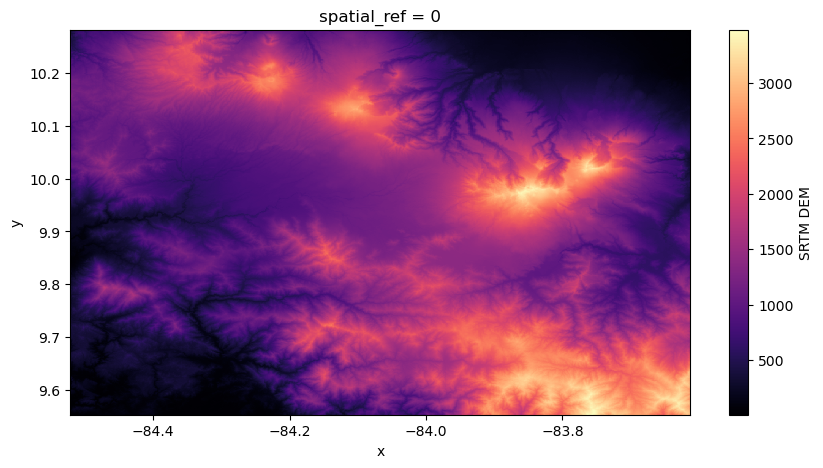

In [ ]:
arr['SRTM DEM'].max("time").plot(figsize=(10, 5), cmap="magma")

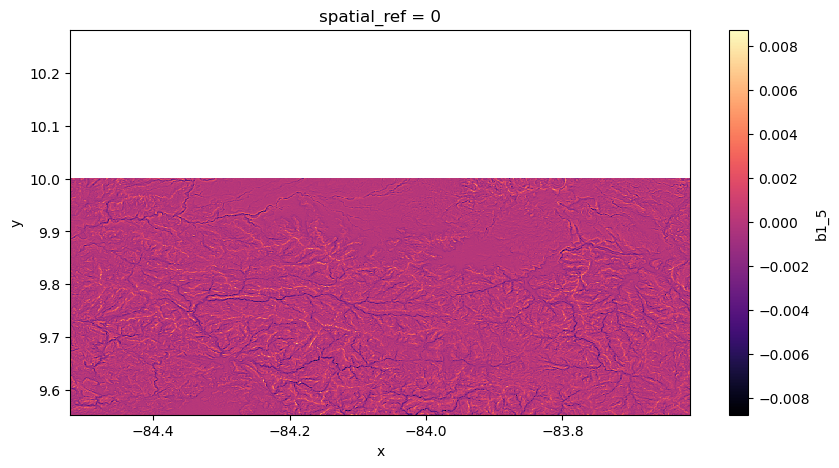

In [ ]:
arr.b1_5.max("time").plot(figsize=(10, 5), cmap="magma")

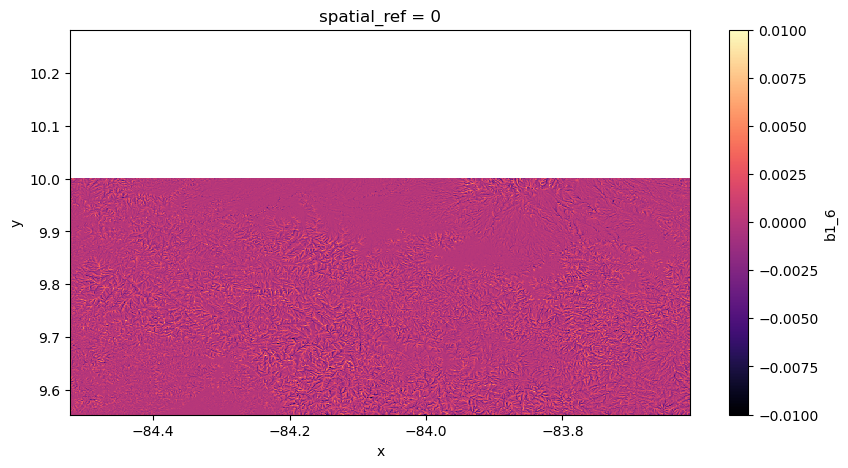

In [ ]:
arr.b1_6.max("time").plot(figsize=(10, 5), cmap="magma")

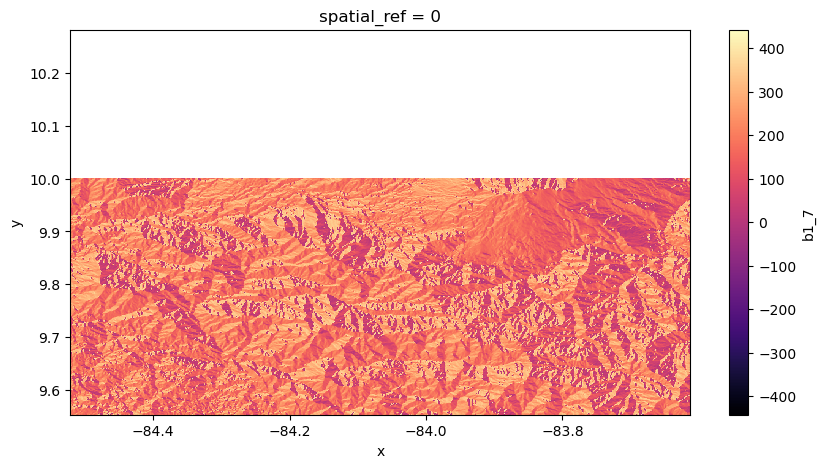

In [ ]:
arr.b1_7.max("time").plot(figsize=(10, 5), cmap="magma")

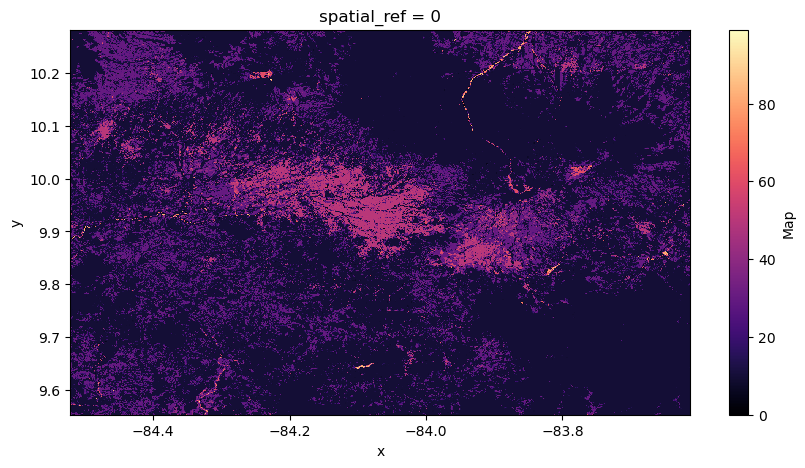

In [ ]:
arr.Map.max("time").plot(figsize=(10, 5), cmap="magma")

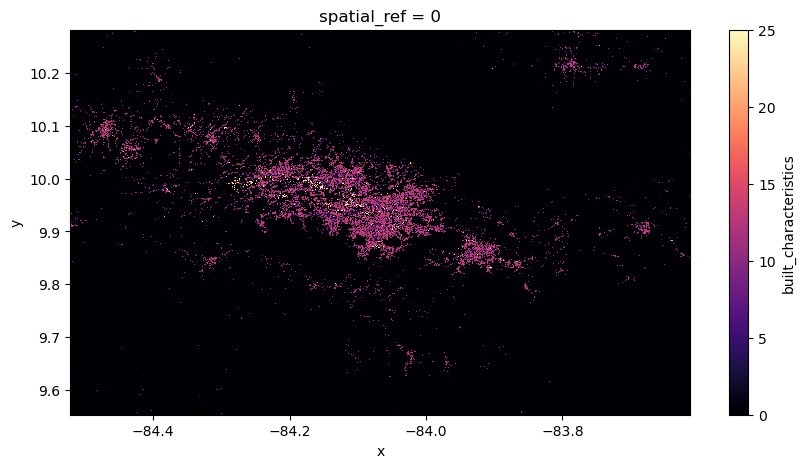

In [ ]:
arr.built_characteristics.max("time").plot(figsize=(10, 5), cmap="magma")

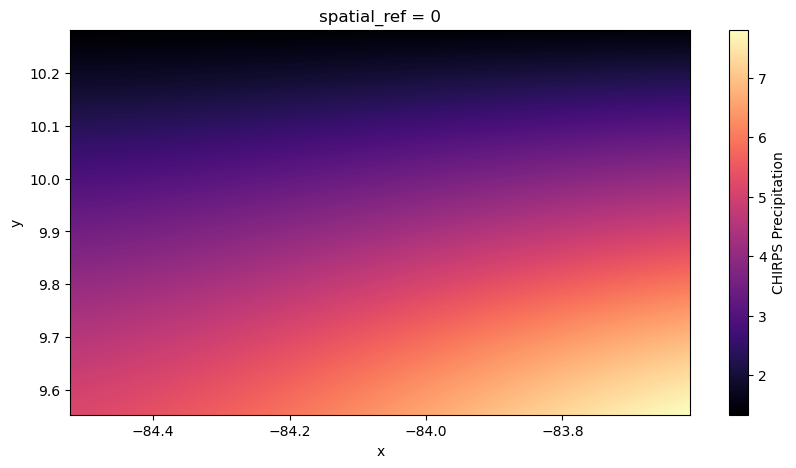

In [ ]:
arr['CHIRPS Precipitation'].max("time").plot(figsize=(10, 5), cmap="magma")
